In [1]:
# Let's import all functions
import numpy as np
import scipy as sp
from qiskit import Aer
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus
from qiskit.circuit import Parameter
import warnings

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\李华宪\AppData\Local\Temp\ipykernel_15576\4067126131.py:5: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation


In [2]:
hamiltonian = (Z ^ Z)

In [3]:
evo_time = Parameter('t')
evolution_op = (evo_time * hamiltonian).exp_i()
print(evolution_op)

e^(-i*1.0*t * ZZ)


In [4]:
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
    trotter_mode='trotter',
    reps=num_time_slices).convert(evolution_op)
trotterized_op.to_circuit().draw()

┌─────────────────────┐
q_0: ┤0                    ├
     │  exp(-it ZZ)(1.0*t) │
q_1: ┤1                    ├
     └─────────────────────┘

In [5]:
hamiltonian = (X ^ X)
evo_time = Parameter('t')
evolution_op = (evo_time * hamiltonian).exp_i()
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
    trotter_mode='trotter',
    reps=num_time_slices).convert(evolution_op)
trotterized_op.to_circuit().draw()

┌─────────────────────┐
q_0: ┤0                    ├
     │  exp(-it XX)(1.0*t) │
q_1: ┤1                    ├
     └─────────────────────┘

In [6]:
hamiltonian = (Y ^ Y)
evo_time = Parameter('t')
evolution_op = (evo_time * hamiltonian).exp_i()
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
    trotter_mode='trotter',
    reps=num_time_slices).convert(evolution_op)
trotterized_op.to_circuit().draw()

┌─────────────────────┐
q_0: ┤0                    ├
     │  exp(-it YY)(1.0*t) │
q_1: ┤1                    ├
     └─────────────────────┘

In [7]:
hamiltonian = (Z ^ Z ^ Z ^ Z)
evo_time = Parameter('t')
evolution_op = (evo_time * hamiltonian).exp_i()
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
    trotter_mode='trotter',
    reps=num_time_slices).convert(evolution_op)
trotterized_op.to_circuit().draw()

┌───────────────────────┐
q_0: ┤0                      ├
     │                       │
q_1: ┤1                      ├
     │  exp(-it ZZZZ)(1.0*t) │
q_2: ┤2                      ├
     │                       │
q_3: ┤3                      ├
     └───────────────────────┘

In [8]:
hamiltonian = (Z ^ Z) + (X ^ X)
observable = (X ^ X)
evo_time = Parameter('t')
evolution_op = (evo_time * hamiltonian).exp_i()

In [9]:
observable_measurement = StateFn(observable).adjoint()

In [10]:
eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
initial_state = StateFn(eigenstates[0])
print(initial_state.to_circuit_op())

CircuitStateFn(
     ┌───────────────────────────────────────────┐
q_0: ┤0                                          ├
     │  State Preparation(0,-0.70711,0,-0.70711) │
q_1: ┤1                                          ├
     └───────────────────────────────────────────┘
) * 0.9999999999999999


In [11]:
evo_and_measure = observable_measurement @ evolution_op @ initial_state
print(evo_and_measure)

ComposedOp([
  OperatorMeasurement(XX),
  e^(-i*1.0*t * (
    1.0 * ZZ
    + 1.0 * XX
  )),
  VectorStateFn(Statevector([ 0.        +0.j, -0.70710678-0.j,  0.        +0.j,
               -0.70710678+0.j],
              dims=(2, 2)))
])


In [12]:
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
    trotter_mode='trotter',
    reps=num_time_slices).convert(evo_and_measure)
print(trotterized_op)

ComposedOp([
  OperatorMeasurement(XX),
       ┌────────────────────────────┐
  q_0: ┤0                           ├
       │  exp(-it (ZZ + XX))(1.0*t) │
  q_1: ┤1                           ├
       └────────────────────────────┘,
  VectorStateFn(Statevector([ 0.        +0.j, -0.70710678-0.j,  0.        +0.j,
               -0.70710678+0.j],
              dims=(2, 2)))
])


In [13]:
# Let's calculate expectation values
diagonalized_meas_op = PauliExpectation().convert(trotterized_op)
print(diagonalized_meas_op)

ComposedOp([
  OperatorMeasurement(ZZ),
       ┌────────────────────────────┐┌───┐
  q_0: ┤0                           ├┤ H ├
       │  exp(-it (ZZ + XX))(1.0*t) │├───┤
  q_1: ┤1                           ├┤ H ├
       └────────────────────────────┘└───┘,
  VectorStateFn(Statevector([ 0.        +0.j, -0.70710678-0.j,  0.        +0.j,
               -0.70710678+0.j],
              dims=(2, 2)))
])


In [14]:
evo_time_points = [0.5, 0.75]
hamiltonian_trotter_expectations = diagonalized_meas_op.bind_parameters({evo_time: evo_time_points})
print(f"Observable at time {evo_time_points}: {np.round(hamiltonian_trotter_expectations.eval(), 3)}")

Observable at time [0.5, 0.75]: [0.+0.j 0.+0.j]


In [15]:
sampler = CircuitSampler(backend=Aer.get_backend("qasm_simulator"))
# sampler.quantum_instance.run_config.shots = 1000
sampled_trotter_exp_op = sampler.convert(hamiltonian_trotter_expectations)
sampled_trotter_energies = sampled_trotter_exp_op.eval()
print(f"Energies: {np.round(np.real(sampled_trotter_energies), 3)}")

Energies: [0.035 0.037]


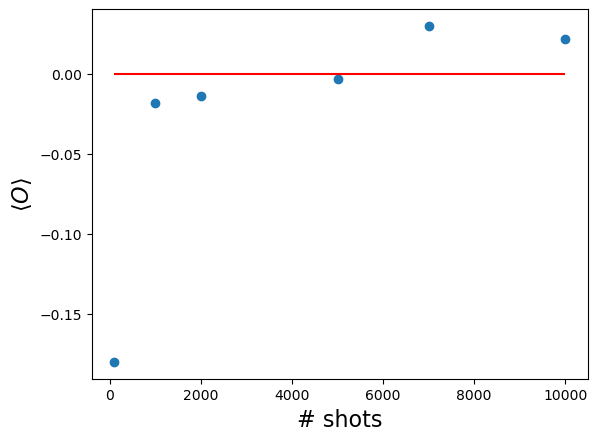

In [16]:
import matplotlib.pyplot as plt


def run_hs(shots):
    sampler = CircuitSampler(backend=Aer.get_backend("qasm_simulator"))
    sampler.quantum_instance.run_config.shots = shots
    hamiltonian_trotter_expectations = diagonalized_meas_op.bind_parameters({evo_time: 0.5})
    sampled_trotter_exp_op = sampler.convert(hamiltonian_trotter_expectations)
    sampled_trotter_energies = sampled_trotter_exp_op.eval()
    return np.real(sampled_trotter_energies)


n_shots = [100, 1000, 2000, 5000, 7000, 10000]
exp = []
for shots in n_shots:
    exp.append(run_hs(shots))

plt.plot(n_shots, exp, 'o', label=f"t={0.5}")
plt.hlines(y=0., xmin=min(n_shots), xmax=max(n_shots) + 1, colors='red')
plt.xlabel("# shots", size=16)
plt.ylabel(r"$ \langle O \rangle $", size=16)
plt.show()